# Carbon Capture - NBEATS

- Exploratory Data Analysis
    - Data Overview
    - Feature Engineering
    - Pre-Processing
- Data Modeling
    - Create NBEATS instance (a generic model for all time-series)
    - Fit the model with all time-series in df
    - Save / load model for future use
    - Forecast on some locations and plot results
    - Create Predictions dataframe
    - Feature Engineering predictions dataframe
- Forecasting with TEST dataset
    - Import Test Dataset
    - Feature Engineering on test dataset
    - Match encoded location from df on test dataset
    - Join predictions based on location and date
    - Export Resuts

### EDA: Data overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Load specific forecasting tools
from darts import TimeSeries
from darts.models import NBEATSModel
from sklearn.preprocessing import LabelEncoder
from darts.dataprocessing.transformers import Scaler
import time
from pylab import rcParams
import datetime

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
# Size of all plots
rcParams['figure.figsize'] = 12,6

In [2]:
df_raw = pd.read_csv('train.csv',index_col=0)

In [3]:
df_raw.head()

,month,year,latitude,longitude,co2
384,0,2000,35.1,-114.5,24.550266
421,0,2000,33.3,-112.8,4.388263
426,0,2000,39.5,-112.5,13.314685
466,0,2000,36.9,-111.3,16.433954
470,0,2000,39.1,-111.1,10.039619


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36276 entries, 384 to 3957963
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   month      36276 non-null  int64  
 1   year       36276 non-null  int64  
 2   latitude   36276 non-null  float64
 3   longitude  36276 non-null  float64
 4   co2        36276 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.7 MB


In [5]:
df_raw.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

In [6]:
df_raw.month.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

### EDA: Feature Engineering

In [7]:
df = df_raw.copy()

In [8]:
# Adding day column for date
df['day'] = 1

# Adding 1 to month to make sure it is ranging from 1-12
df['month'] = df['month']+ 1

In [9]:
# Create column in datetime data type
df['date'] = pd.to_datetime(df[['year','month','day']])

In [10]:
# Create a column with tuple containing latitude and longitude together
df['lat_long'] = list(zip(df['latitude'], df['longitude']))

In [11]:
df['lat_long'].nunique()

153

In [12]:
# drop unnecesary / redundant data 
df.drop(labels=['month','year','day','longitude','latitude'],axis=1,inplace=True)

In [13]:
df.head()

,co2,date,lat_long
384,24.550266,2000-01-01,"(35.1, -114.5)"
421,4.388263,2000-01-01,"(33.3, -112.8)"
426,13.314685,2000-01-01,"(39.5, -112.5)"
466,16.433954,2000-01-01,"(36.9, -111.3)"
470,10.039619,2000-01-01,"(39.1, -111.1)"


In [14]:
# pivot dataset to have better appreciation of all time-series per location
df_pivot = df.pivot(index='date', columns = 'lat_long', values='co2')
df_pivot = df_pivot.sort_index()

In [15]:
# Set Date frquency to Monthly Data
freq_time = 'MS' 
df_pivot = df_pivot.resample(freq_time).mean()
df_pivot.index.freq = freq_time

In [16]:
df_pivot.head()

lat_long,"(25.8, -97.8)","(26.6, -81.7)","(27.0, -80.5)","(27.6, -82.3)","(27.7, -82.4)","(27.9, -82.4)","(28.3, -100.8)","(28.4, -81.1)","(28.8, -81.3)","(29.0, -110.9)",...,"(45.8, -106.6)","(47.0, -101.2)","(47.2, -101.3)","(47.2, -93.6)","(47.3, -101.8)","(47.3, -101.1)","(47.9, -65.9)","(49.0, -105.4)","(49.0, -103.0)","(49.0, -102.8)"
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,4.024838,4.076302,8.681103,4.254332,8.166128,2.724895,4.902469,5.893239,5.733449,2.431313,...,18.777016,6.443851,5.556982,7.820921,7.988350,11.437829,6.611117,11.044418,16.489307,5.585770
2000-02-01,3.857137,3.475400,7.401391,3.627186,6.962330,2.323208,4.698199,5.024495,4.888261,2.330008,...,16.009029,5.493940,4.737808,6.668012,6.810759,9.751738,6.611117,10.237016,15.283857,5.177423
2000-03-01,3.521733,3.406172,7.253960,3.554935,6.823645,2.276932,4.289660,4.924411,4.790890,2.127399,...,15.690140,5.384504,4.643434,6.535189,6.675093,9.557490,6.611117,10.233405,15.278464,5.175596
2000-04-01,3.354032,3.071030,6.540224,3.205155,6.152249,2.052898,4.085391,4.439885,4.319502,2.026094,...,14.146346,4.854709,4.186555,5.892175,6.018313,8.617104,6.611117,8.750677,13.064754,4.425699
2000-05-01,3.018629,3.443486,7.333427,3.593878,6.898398,2.301875,3.676852,4.978357,4.843374,1.823485,...,15.862024,5.443491,4.694303,6.606781,6.748218,9.662191,6.611117,8.377229,12.507195,4.236826


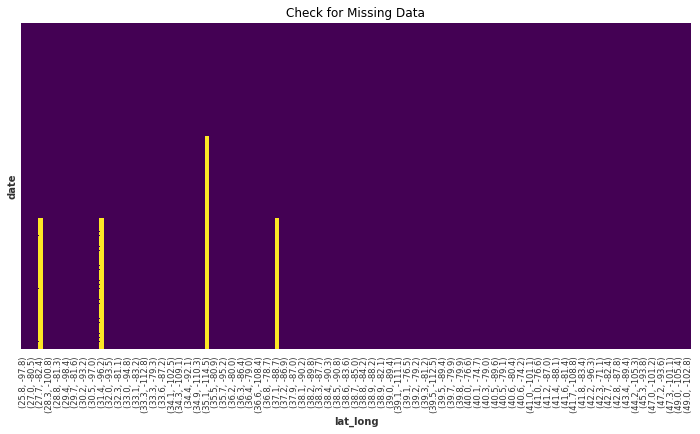

In [17]:
#Use heatmap to identify mising data
ax = plt.axes()
ax.set_title('Check for Missing Data')
sns.heatmap(df_pivot.isnull(),yticklabels=False,cbar=False,cmap='viridis',ax=ax);

In [18]:
df_pivot.isnull().sum().sort_values(ascending=False).head(10)

lat_long
(35.1, -114.5)    156
(31.4, -96.2)      96
(37.1, -88.7)      96
(27.7, -82.4)      96
(36.2, -80.0)       0
(36.6, -108.4)      0
(36.5, -89.5)       0
(36.4, -79.0)       0
(36.4, -97.0)       0
(36.3, -86.4)       0
dtype: int64

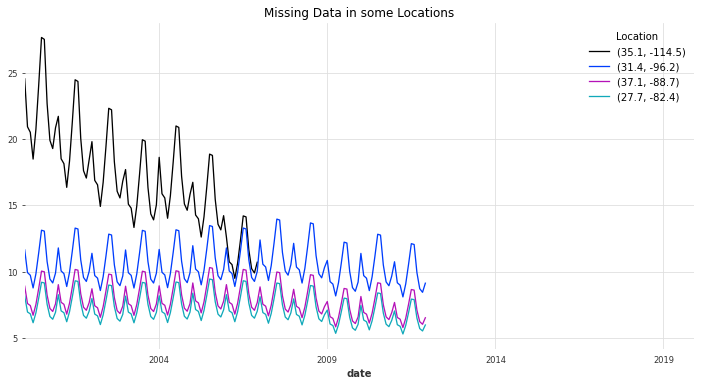

In [19]:
df_pivot[(35.1, -114.5)].plot()
df_pivot[(31.4, -96.2)].plot()
df_pivot[(37.1, -88.7)].plot()
df_pivot[(27.7, -82.4)].plot()
plt.legend(title='Location')
plt.title('Missing Data in some Locations');

In [20]:
#Remove locations with missing data
df_pivot.drop(labels=[(35.1, -114.5),
                     (31.4, -96.2),
                     (37.1, -88.7),
                     (27.7, -82.4)],axis=1,inplace=True)

In [21]:
df_pivot.isnull().sum().sort_values(ascending=False).head(10)

lat_long
(49.0, -102.8)    0
(36.9, -111.3)    0
(36.8, -108.4)    0
(36.6, -108.4)    0
(36.5, -89.5)     0
(36.4, -79.0)     0
(36.4, -97.0)     0
(36.3, -86.4)     0
(36.3, -87.6)     0
(36.2, -80.0)     0
dtype: int64

In [22]:
# df without null values.
df = df_pivot.melt(var_name='lat_long',value_name='co2',ignore_index=False)

In [23]:
df

,lat_long,co2
date,,
2000-01-01,"(25.8, -97.8)",4.024838
2000-02-01,"(25.8, -97.8)",3.857137
2000-03-01,"(25.8, -97.8)",3.521733
2000-04-01,"(25.8, -97.8)",3.354032
2000-05-01,"(25.8, -97.8)",3.018629
...,...,...
2019-08-01,"(49.0, -102.8)",3.691653
2019-09-01,"(49.0, -102.8)",3.358604
2019-10-01,"(49.0, -102.8)",3.460907


In [24]:
#Create encoded column based on lat_long
label_encoder = LabelEncoder()
df['lat_long2'] = df['lat_long'].astype('string')
df['location'] = label_encoder.fit_transform(df['lat_long2'])
df = df.sort_index()

In [25]:
df.head()

,lat_long,co2,lat_long2,location
date,,,,
2000-01-01,"(25.8, -97.8)",4.024838,"(25.8, -97.8)",0
2000-01-01,"(35.5, -80.9)",12.041616,"(35.5, -80.9)",41
2000-01-01,"(36.4, -97.0)",6.420758,"(36.4, -97.0)",49
2000-01-01,"(40.2, -80.6)",10.188225,"(40.2, -80.6)",101
2000-01-01,"(38.6, -83.6)",11.102073,"(38.6, -83.6)",70


In [26]:
df[['lat_long','location']].sort_values(by='location')

,lat_long,location
date,,
2000-01-01,"(25.8, -97.8)",0
2004-05-01,"(25.8, -97.8)",0
2014-11-01,"(25.8, -97.8)",0
2010-11-01,"(25.8, -97.8)",0
2004-04-01,"(25.8, -97.8)",0
...,...,...
2005-04-01,"(49.0, -105.4)",148
2017-08-01,"(49.0, -105.4)",148
2013-10-01,"(49.0, -105.4)",148


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35760 entries, 2000-01-01 to 2019-12-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat_long   35760 non-null  object 
 1   co2        35760 non-null  float64
 2   lat_long2  35760 non-null  string 
 3   location   35760 non-null  int32  
dtypes: float64(1), int32(1), object(1), string(1)
memory usage: 1.2+ MB


In [28]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
co2,35760.0,8.083218,3.926168,0.924653,5.199244,7.036835,10.071969,31.149539
location,35760.0,74.000000,43.012228,0.000000,37.000000,74.000000,111.000000,148.000000


 ### EDA: *Pre-Processing*

In [29]:
df1 = df[['co2','location']]

In [30]:
df1.shape

(35760, 2)

In [31]:
df1.head()

,co2,location
date,,
2000-01-01,4.024838,0
2000-01-01,12.041616,41
2000-01-01,6.420758,49
2000-01-01,10.188225,101
2000-01-01,11.102073,70


In [32]:
#how many data points we have per time-series?
len(df1.pivot(columns = 'location', values='co2')[0])

240

In [33]:
# Encoded locations available
np.sort(df1['location'].unique())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148])

In [34]:
print('********** Visualize darts Time-series data *************')
TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[0]].reset_index().rename_axis(None, axis=1),time_col='date')

********** Visualize darts Time-series data *************


<TimeSeries (DataArray) (date: 240, component: 1, sample: 1)>
array([[[4.02483837]],

       [[3.85713663]],

       [[3.52173343]],

       [[3.35403198]],

       [[3.01862878]],

       [[2.85092703]],

       [[2.68322558]],

       [[2.93477806]],

       [[3.18633053]],

       [[3.35403198]],

...

       [[4.80718357]],

       [[4.57827049]],

       [[4.12044344]],

       [[3.89153006]],

       [[3.6626161 ]],

       [[4.00598675]],

       [[4.34935741]],

       [[4.57827049]],

       [[4.92164085]],

       [[5.26501062]]])
Coordinates:
  * date       (date) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-12-01
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

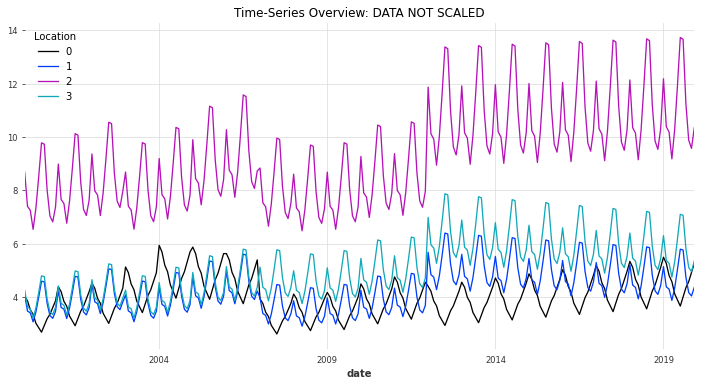

In [35]:
# Plot some of the time-series data. It was noticed data needs to be scaled.
df1.pivot(columns = 'location', values='co2')[0].plot()
df1.pivot(columns = 'location', values='co2')[1].plot()
df1.pivot(columns = 'location', values='co2')[2].plot()
df1.pivot(columns = 'location', values='co2')[3].plot()
plt.legend(title='Location')
plt.title('Time-Series Overview: DATA NOT SCALED');

In [36]:
scaler_co2 = Scaler()

In [37]:
#This loop is used to create two lists: 
    #scaled time-series per location and 
    # unscaled Time-Series per location 
# Also, we convert to timeseries data type from darts)
#This is done so we can feed the model with the scaled data.
location_list = []
location_list_transf = []
for location in np.sort(df1['location'].unique()).tolist():
    location_list.append(TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[location]].reset_index().rename_axis(None, axis=1),time_col='date'))
    location_list_transf.append(scaler_co2.fit_transform(TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[location]].reset_index().rename_axis(None, axis=1),time_col='date')))

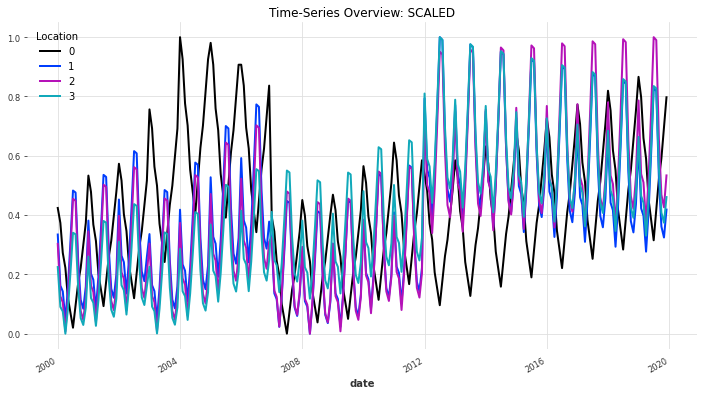

In [38]:
location_list_transf[0].plot()
location_list_transf[1].plot()
location_list_transf[2].plot()
location_list_transf[3].plot()
plt.legend(title='Location')
plt.title('Time-Series Overview: SCALED');

### Data Modeling
- Create NBEATS instance (a generic model for all time-series)
- Fit the model with all time-series in df
- Save / load model for future use
- Evaluate model's performance
- Forecast on some locations and plot results
- Invert Transformed data (Return to original scale)
- Create Predictions dataframe
- Feature Engineering predictions dataframe

In [39]:
# The model will be saved so it can be used in the future. Therefore, we set the following variables:

load = True
SAVE = "\_NBEATS_model_Rev03.pth.tar" #filename
mpath = os.path.abspath(os.getcwd()) + SAVE # path and file name to save the model
print(os.getcwd())

C:\Users\anton\Google Drive\Master in Data Science\Independent Projects\9. Carbon Capture Challenge\Code


In [40]:
# training: load a saved model or (re)train
if load:
    print("have loaded a previously saved model from disk:" + mpath)
    model = NBEATSModel.load_model(mpath)                            # load previously model from disk
else:
    model = NBEATSModel(input_chunk_length=48,
                        output_chunk_length=12,                        
                        random_state=0)
    model.fit(location_list_transf,verbose=True,epochs=100)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

have loaded a previously saved model from disk:C:\Users\anton\Google Drive\Master in Data Science\Independent Projects\9. Carbon Capture Challenge\Code\_NBEATS_model_Rev03.pth.tar


2022-05-23 00:54:21 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-05-23 00:54:21 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-05-23 00:54:21 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-05-23 00:54:21 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

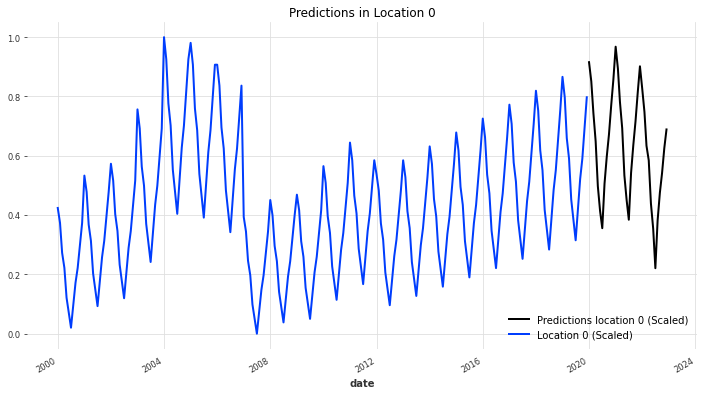

In [41]:
model.predict(n=36,series=location_list_transf[0]).plot(label='Predictions location 0 (Scaled)')
location_list_transf[0].plot(label='Location 0 (Scaled)')
plt.title('Predictions in Location 0');

Predicting: 0it [00:00, ?it/s]

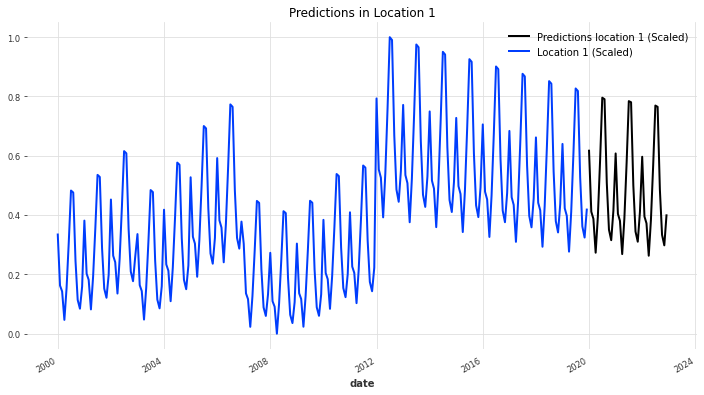

In [42]:
model.predict(n=36,series=location_list_transf[1]).plot(label='Predictions location 1 (Scaled)')
location_list_transf[1].plot(label='Location 1 (Scaled)')
plt.title('Predictions in Location 1');

Predicting: 0it [00:00, ?it/s]

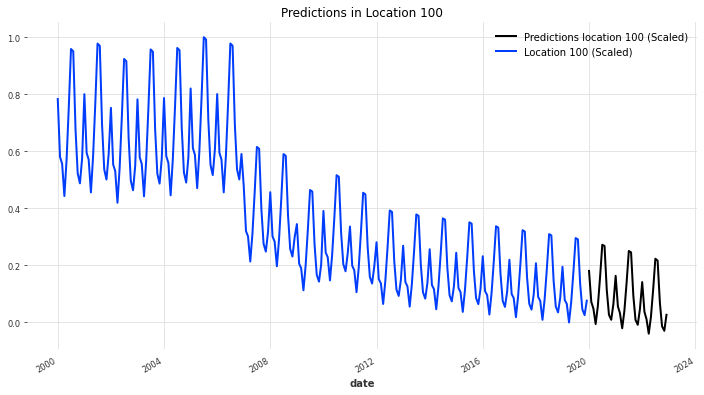

In [43]:
model.predict(n=36,series=location_list_transf[100]).plot(label='Predictions location 100 (Scaled)')
location_list_transf[100].plot(label='Location 100 (Scaled)')
plt.title('Predictions in Location 100');

In [44]:
# Inverse transformation of time-series data

for location in range(df['location'].max()+1):
    scaler_co2.fit_transform(TimeSeries.from_dataframe(df1.pivot(columns='location',values='co2')[[location]].reset_index().rename_axis(None, axis=1),time_col='date'))
    if location == 0:
        predictions = scaler_co2.inverse_transform(model.predict(n=12,series=location_list_transf[location])).pd_dataframe()
    else:
        predictions[str(location)] = scaler_co2.inverse_transform(model.predict(n=12,series=location_list_transf[location])).pd_dataframe()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [45]:
predictions.head()

component,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,5.658098,5.062997,12.213481,6.168030,5.778757,8.012286,5.287026,6.075351,2.029361,15.469808,...,12.627400,5.296569,5.448915,6.018748,9.731688,7.527030,5.880069,4.085052,8.011942,9.539513
2020-02-01,5.443405,4.345372,10.440297,5.287899,4.942375,7.332277,4.533532,5.210137,2.128103,13.259288,...,10.843094,4.539025,4.668463,5.157914,8.339808,6.450472,5.903692,3.786427,7.360987,8.853570
2020-03-01,5.087947,4.261081,10.238750,5.189718,4.861731,6.442538,4.435293,5.110269,1.948161,12.956982,...,10.555189,4.429282,4.556059,5.033208,8.138172,6.294515,5.903502,3.815700,7.441686,8.874344
2020-04-01,4.771526,3.862153,9.281193,4.705782,4.405781,6.251610,4.030179,4.635135,1.805631,11.780393,...,9.623825,4.030463,4.144762,4.580010,7.405398,5.727748,5.889614,3.255331,6.346014,7.575665
2020-05-01,4.268914,4.281680,10.325798,5.218614,4.876879,5.540140,4.480806,5.148161,1.714446,13.082461,...,10.653256,4.473477,4.600576,5.083428,8.219373,6.357321,5.862139,3.102566,5.982933,7.211506


In [46]:
predictions = predictions.melt(value_vars=predictions.iloc[:,:].columns,var_name='location',value_name='co2',ignore_index=False)

In [47]:
predictions['location'] = predictions['location'].astype(int)

In [48]:
predictions.head()

,location,co2
date,,
2020-01-01,0,5.658098
2020-02-01,0,5.443405
2020-03-01,0,5.087947
2020-04-01,0,4.771526
2020-05-01,0,4.268914


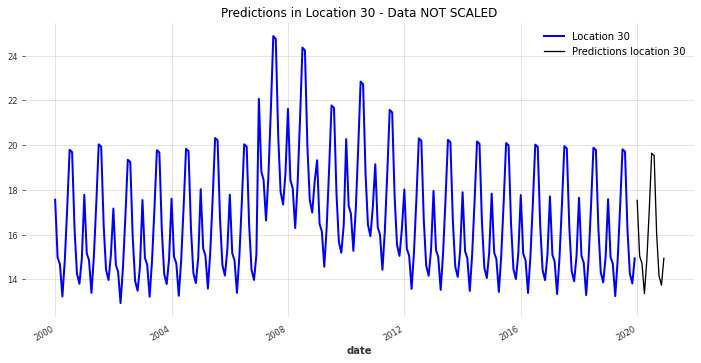

In [49]:

location_list[30].plot(label='Location 30',color='blue')
predictions[predictions['location']==30]['co2'].plot(label='Predictions location 30',color='black')
plt.title('Predictions in Location 30 - Data NOT SCALED');
plt.legend();

### Forecasting with TEST dataset

- Import Test Dataset
- Feature Engineering on test dataset
- Match encoded location from df on test dataset
- Join predictions based on location and date
- Export Resuts

In [50]:
test_raw = pd.read_csv('test.csv',index_col=False)

In [51]:
test = test_raw.copy()

In [52]:
# Test dataset Feature Engineering
test['day'] = 1
test['month'] = test['month']+ 1
test['date'] = pd.to_datetime(test[['year','month','day']])
test['lat_long'] = list(zip(test['latitude'], test['longitude']))

In [53]:
test.head(2)

,Unnamed: 0,month,year,latitude,longitude,day,date,lat_long
0,3970411,1,2020,33.3,-112.8,1,2020-01-01,"(33.3, -112.8)"
1,3970420,1,2020,39.5,-112.5,1,2020-01-01,"(39.5, -112.5)"


In [54]:
test.drop(labels=['Unnamed: 0','month','year','day','longitude','latitude'],axis=1,inplace=True)

In [55]:
query = []
for coor in range(len(test)):
    query.append(df[df['lat_long'] == test['lat_long'][coor]]['location'].unique()[0])
test['location'] = query

In [56]:
results = pd.merge(left=test, right=predictions, how='left', on=['date','location'])

In [57]:
# Export Results (uncomment lines below to export results)
# results = round(results['co2'],4)
# results.to_csv('Submission_Antonio-Aamer.csv',index=False)

### END
- Authors: Antonio Dagnino Mendez, Aamer Kazi
- Date: May-2022